### Importation packages

In [1]:
import os
import re
import glob
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import missingno as msno

from zipfile import ZipFile

### Paramétrages globaux

In [2]:
# Paramétrage dimensions pandas
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 1000)

# Paramétrage graphique seaborn
sns.set_theme(style="whitegrid")

### Fonctions

In [3]:
# Fonction de descritpion générale des élméments du dataset
def data_describe(folder):

    data_dict = {}
    for file in folder:
        print("processing ", file, ":")
        data = pd.read_csv(file, encoding_errors = 'ignore')
        data_dict[file] = [data.shape[0], 
                           data.shape[1],
                            round(data.isna().sum().sum()/data.size*100, 2),
                            round(data.duplicated().sum().sum()/data.size*100, 2),
                            data.select_dtypes(include = ['object']).shape[1],
                            data.select_dtypes(include = ['float']).shape[1],
                            data.select_dtypes(include = ['int']).shape[1],
                            data.select_dtypes(include = ['bool']).shape[1],
                            round(data.memory_usage().sum()/1024**2, 3)]

        comparative_table = pd.DataFrame.from_dict(data = data_dict, 
                                                   columns = ['Rows', 'Columns', '%NaN', '%Duplicate', 
                                                              'object_dtype', 'float_dtype', 'int_dtype', 
                                                              'bool_dtype', 'MB_Memory'], 
                                                   orient = 'index')
    print("Files summary :")
    return(comparative_table)

In [4]:
# Fonction de description des features du dataset
def features(folder):

    data_object = {}
    data_numeric = {}
    
    for file in folder:
        data = pd.read_csv(file, encoding_errors = 'ignore')
        
        data_object[file] = [(x, data[x].dtype, 
                              data[x].isna().sum().sum(),
                              int(data[x].count())) for x in data.select_dtypes(exclude = ['int', 'float'])]
        
        data_numeric[file] = [(x, data[x].dtype, 
                               int(data[x].isna().sum().sum()), 
                               int(data[x].count()), 
                               int(data[x].mean()), 
                               round(data[x].std(),1),
                               round(data[x].min(),1), 
                               round(data[x].max(),1)) for x in data.select_dtypes(exclude = 'object')]
        

    comparative_object = pd.DataFrame.from_dict(data = data_object, orient='index')
    dict_of_object = {name: pd.DataFrame(file) for name, file in data_object.items()}
    df1 = pd.concat(dict_of_object, axis = 0)
    df1.columns=['features', 'dtype', 'nan', 'count']
    
    comparative_numeric = pd.DataFrame.from_dict(data = data_numeric, orient='index')
    dict_of_numeric = {name: pd.DataFrame(file) for name,file in data_numeric.items()}
    df2 = pd.concat(dict_of_numeric, axis = 0)
    df2.columns = ['features', 'dtype', 'nan', 'count', 'mean', 'std', 'min', 'max']
        
    return df1, df2

In [5]:
# Fonction générale d'observatino des valeurs nulles
def missing_values(data, plot = False):
    mst = pd.DataFrame(
        {"Num_Missing": data.isnull().sum(), 
         "Missing_Ratio": data.isnull().sum() / data.shape[0]}).sort_values(
        "Num_Missing", ascending=False)
    mst["DataTypes"] = data[mst.index].dtypes.values
    mst = mst[mst.Num_Missing > 0].reset_index().rename(
        {"index": "Feature"}, axis = 1)

    print("Number of Variables including Missing Values:", mst.shape[0], "\n")

    if mst[mst.Missing_Ratio >= 1.0].shape[0] > 0:
        print("Full Missing Variables:",
              mst[mst.Missing_Ratio >= 1.0].Feature.tolist())
        data.drop(mst[mst.Missing_Ratio >= 1.0].Feature.tolist(),
                  axis = 1, inplace = True)

        print("Full missing variables are deleted!", "\n")

    if plot:
        plt.figure(figsize = (25, 8))
        p = sns.barplot(mst.Feature, mst.Missing_Ratio)
        for rotate in p.get_xticklabels():
            rotate.set_rotation(90)
        plt.show()

    print(mst, "\n")

In [27]:
# Fonction de génération d'un graphique en barres
def display_barplot(data=None, x=None, y=None, title='Barplot', figsize=(8, 6),
                    order=None, palette=None, xrotation=0, ylabel=None):
    plt.figure(figsize=figsize)
    plt.title(title)
    sns.barplot(data=data, x=x, y=y, order=order, palette=palette)
    if ylabel is not None:
        plt.ylabel(ylabel)
    plt.xticks(rotation=xrotation)
    plt.show()

In [44]:
# Fonction de génération d'un histogramme
def display_histplot(data, x = None, y = None, title = 'Histplot', figsize = (8, 6), kde = False, hue = None,
                     bins = 'auto'):
    plt.figure(figsize = figsize)
    plt.title(title)
    sns.histplot(data = data, x = x, y = y, kde = kde, hue = hue, bins = bins)
    plt.show()

In [31]:
# Fonction histogramme : répartition de la target en fonction d'une feature définie
def plot_stats(feature, label_rotation=False, horizontal_layout = True):
    temp = train[feature].value_counts()
    df1 = pd.DataFrame({feature: temp.index, 'Nb': temp.values})

    # calcul pourcentage de TARGET == 1
    cat_perc = train[[feature, 'TARGET']].groupby([feature], as_index = False).mean()
    cat_perc.sort_values(by = 'TARGET', ascending = False, inplace = True)
    
    if(horizontal_layout):
        fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (12,6))
    else:
        fig, (ax1, ax2) = plt.subplots(nrows = 2, figsize = (12,14))
    sns.set_color_codes("pastel")
    s = sns.barplot(ax = ax1, x = feature, y = "Nb", data = df1)
    
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(), rotation=90)
    
    s = sns.barplot(ax = ax2, x = feature, y = 'TARGET', order = cat_perc[feature], data = cat_perc)
    
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(), rotation = 90)
    plt.ylabel('Incidents de paiements (%)', fontsize = 10)
    plt.tick_params(axis = 'both', which = 'major', labelsize = 10)

    plt.show(xrotation = 60)

In [33]:
# Fonction d'affichage d'une distribution
def plot_distribution(feature):
    plt.figure(figsize=(20,6))

    t0 = train.loc[train['TARGET'] == 0]
    t1 = train.loc[train['TARGET'] == 1]

    
    sns.kdeplot(t0[feature].dropna(), color='blue', label = "TARGET = 0")
    sns.kdeplot(t1[feature].dropna(), color='red', label = "TARGET = 1")
    plt.title('Distribution selon {}'.format(feature))
    plt.ylabel('')
    plt.legend()
    plt.show() 

In [29]:
# Fonction d'affichage des différentes catégories selon la TARGET
def display_repay_failure_category(data, column, limit=None):

    grouped_data = data[[column, TARGET]].groupby(column).mean().reset_index()
    grouped_data = grouped_data.sort_values(by=TARGET, ascending=False)

    categories = grouped_data[column].unique()
    n_categories = grouped_data[column].nunique()
    avg_len = sum(map(len, categories)) / n_categories

    xrotation=70 if avg_len > 4 else 0
    
    figsize=(6, 6) if n_categories < 4 else (12, 6)

    display_barplot(grouped_data, x=column, y=TARGET, xrotation=xrotation, figsize=figsize,
                    title = "Incident de paiement (target == 1) selon " + column, ylabel = "Incidents de paiements %")

In [8]:
# Fonction de représentation des incidents de paiements selon type de prêt
def plot_percent_target1(data, feature, title) : 
    
    cat_perc = data[[feature, 'TARGET']].groupby([feature], as_index = False).mean()
    cat_perc.sort_values(by = 'TARGET', ascending = False, inplace = True)
    
    ax, fig = plt.subplots(figsize = (20,8)) 
    ax = sns.barplot(y = feature, x = 'TARGET', data = cat_perc)
    ax.set_title(title)
    ax.set_xlabel("")
    ax.set_ylabel("Pourcentage d'incidents de paiements (target = 1)")

    for p in ax.patches:
                percentage = '{:.1f}%'.format(100 * p.get_width())
                x = p.get_x() + p.get_width()
                y = p.get_y() + p.get_height()/2
                ax.annotate(percentage, (x, y), fontsize = 20, fontweight = 'bold')

    plt.show()

## 1. Ouverture et aperçu du dataset

In [9]:
# Chemin du dataset
path = './external_files/'
folder_path = glob.glob('./external_files/*.csv')

# Liste des fichiers du dataset (total : 10), et renommage
train = pd.read_csv(path + 'application_train.csv')
train.name = 'train'

test = pd.read_csv(path + 'application_test.csv')
test.name = 'test'

bureau = pd.read_csv(path + 'bureau.csv')
bureau.name = 'bureau'

bureau_bal = pd.read_csv(path + 'bureau_balance.csv')
bureau_bal.name = 'bureau_bal'

pos_cash_bal = pd.read_csv(path + 'POS_CASH_balance.csv')
pos_cash_bal.name = 'pos_cash_bal'

cred_card_bal = pd.read_csv(path + 'credit_card_balance.csv')
cred_card_bal.name = 'cred_card_bal'

prev_app = pd.read_csv(path + 'previous_application.csv')
prev_app.name = 'prev_app'

install_pay = pd.read_csv(path + 'installments_payments.csv')
install_pay.name = 'install_pay'

col_descr = pd.read_csv(path + 'HomeCredit_columns_description.csv', encoding_errors='ignore')
col_descr.name = 'col_descr'

sample_sub = pd.read_csv(path + 'sample_submission.csv', encoding_errors='ignore')
sample_sub.name = 'sample_sub'

In [10]:
# Définition des liste de fichiers
dataset = [train, test, bureau, bureau_bal,
           pos_cash_bal, cred_card_bal, prev_app, install_pay, col_descr]

data_list = ['train', 'test', 'bureau', 'bureau_bal',
           'pos_cash_bal', 'cred_card_bal', 'prev_app', 'install_pay', 'col_descr']

In [11]:
# Boucle d'aperçu de chaque fichier du Dataset
for file in dataset:
    print(file.name)
    print()
    print('format : {}'.format(file.shape))
    print('columns : {}'.format(file.columns.to_list()))
    display(file.head())

train

format : (307511, 122)
columns : ['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', '

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

test

format : (48744, 121)
columns : ['SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.752614,0.789654,0.159520,0.0660,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0505,NaN,NaN,0.0672,0.0612,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0526,NaN,NaN,0.0666,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0514,NaN,NaN,NaN,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.564990,0.291656,0.432962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019101,-20038,-4458,-2175.0,-3503,5.0,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,NaN,0.699787,0.610991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secondary / secondary special,Married

bureau

format : (1716428, 17)
columns : ['SK_ID_CURR', 'SK_ID_BUREAU', 'CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE', 'CREDIT_TYPE', 'DAYS_CREDIT_UPDATE', 'AMT_ANNUITY']


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


bureau_bal

format : (27299925, 3)
columns : ['SK_ID_BUREAU', 'MONTHS_BALANCE', 'STATUS']


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


pos_cash_bal

format : (10001358, 8)
columns : ['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'CNT_INSTALMENT', 'CNT_INSTALMENT_FUTURE', 'NAME_CONTRACT_STATUS', 'SK_DPD', 'SK_DPD_DEF']


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


cred_card_bal

format : (3840312, 23)
columns : ['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'AMT_BALANCE', 'AMT_CREDIT_LIMIT_ACTUAL', 'AMT_DRAWINGS_ATM_CURRENT', 'AMT_DRAWINGS_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT', 'AMT_DRAWINGS_POS_CURRENT', 'AMT_INST_MIN_REGULARITY', 'AMT_PAYMENT_CURRENT', 'AMT_PAYMENT_TOTAL_CURRENT', 'AMT_RECEIVABLE_PRINCIPAL', 'AMT_RECIVABLE', 'AMT_TOTAL_RECEIVABLE', 'CNT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_CURRENT', 'CNT_DRAWINGS_OTHER_CURRENT', 'CNT_DRAWINGS_POS_CURRENT', 'CNT_INSTALMENT_MATURE_CUM', 'NAME_CONTRACT_STATUS', 'SK_DPD', 'SK_DPD_DEF']


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,1800.0,1800.0,0.000,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,2250.0,2250.0,60175.080,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,2250.0,2250.0,26926.425,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,11925.0,11925.0,224949.285,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,27000.0,27000.0,443044.395,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


prev_app

format : (1670214, 37)
columns : ['SK_ID_PREV', 'SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'AMT_ANNUITY', 'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT', 'AMT_GOODS_PRICE', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'FLAG_LAST_APPL_PER_CONTRACT', 'NFLAG_LAST_APPL_IN_DAY', 'RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY', 'RATE_INTEREST_PRIVILEGED', 'NAME_CASH_LOAN_PURPOSE', 'NAME_CONTRACT_STATUS', 'DAYS_DECISION', 'NAME_PAYMENT_TYPE', 'CODE_REJECT_REASON', 'NAME_TYPE_SUITE', 'NAME_CLIENT_TYPE', 'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE', 'CHANNEL_TYPE', 'SELLERPLACE_AREA', 'NAME_SELLER_INDUSTRY', 'CNT_PAYMENT', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION', 'NFLAG_INSURED_ON_APPROVAL']


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


install_pay

format : (13605401, 8)
columns : ['SK_ID_PREV', 'SK_ID_CURR', 'NUM_INSTALMENT_VERSION', 'NUM_INSTALMENT_NUMBER', 'DAYS_INSTALMENT', 'DAYS_ENTRY_PAYMENT', 'AMT_INSTALMENT', 'AMT_PAYMENT']


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


col_descr

format : (219, 5)
columns : ['Unnamed: 0', 'Table', 'Row', 'Description', 'Special']


,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,"Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)",NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN


In [12]:
# Appel de la fonction data_describe sur le chemin défini
data_describe(folder_path)

processing  ./Files\application_test.csv :
processing  ./Files\application_train.csv :
processing  ./Files\bureau.csv :
processing  ./Files\bureau_balance.csv :
processing  ./Files\credit_card_balance.csv :
processing  ./Files\HomeCredit_columns_description.csv :
processing  ./Files\installments_payments.csv :
processing  ./Files\POS_CASH_balance.csv :
processing  ./Files\previous_application.csv :
processing  ./Files\sample_submission.csv :
Files summary :


,Rows,Columns,%NaN,%Duplicate,object_dtype,float_dtype,int_dtype,bool_dtype,MB_Memory
./Files\application_test.csv,48744,121,23.81,0.0,16,65,40,0,44.998
./Files\application_train.csv,307511,122,24.40,0.0,16,65,41,0,286.227
./Files\bureau.csv,1716428,17,13.50,0.0,3,8,6,0,222.620
./Files\bureau_balance.csv,27299925,3,0.00,0.0,1,0,2,0,624.846
./Files\credit_card_balance.csv,3840312,23,6.65,0.0,1,15,7,0,673.883
./Files\HomeCredit_columns_description.csv,219,5,12.15,0.0,4,0,1,0,0.008
./Files\installments_payments.csv,13605401,8,0.01,0.0,0,5,3,0,830.408
./Files\POS_CASH_balance.csv,10001358,8,0.07,0.0,1,2,5,0,610.435
./Files\previous_application.csv,1670214,37,17.98,0.0,16,15,6,0,471.481
./Files\sample_submission.csv,48744,2,0.00,0.0,0,1,1,0,0.744


In [13]:
# Paramètres affichage
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000

# Appel de la fonction features : aperçu des features 'object' du dataset
features(folder = folder_path)[0]

features   dtype       nan       count
./Files\application_test.csv               0            NAME_CONTRACT_TYPE  object       0.0     48744.0
                                           1                   CODE_GENDER  object       0.0     48744.0
                                           2                  FLAG_OWN_CAR  object       0.0     48744.0
                                           3               FLAG_OWN_REALTY  object       0.0     48744.0
                                           4               NAME_TYPE_SUITE  object     911.0     47833.0
                                           5              NAME_INCOME_TYPE  object       0.0     48744.0
                                           6           NAME_EDUCATION_TYPE  object       0.0     48744.0
                                           7            NAME_FAMILY_STATUS  object       0.0     48744.0
                                           8             NAME_HOUSING_TYPE  object       0.0     48744.0
                                           9               OCCUPATION_TYPE  object   15605.0     33139.0
                                           10   WEEKDAY_APPR_PROCESS_START  object       0.0     48744.0
                                           11            ORGANIZATION_TYPE  object       0.0     48744.0
                                           12           FONDKAPREMONT_MODE  object   32797.0     15947.0
                                           13               HOUSETYPE_MODE  object   23619.0     25125.0
                                           14           WALLSMATERIAL_MODE  object   23893.0     24851.0
                                           15          EMERGENCYSTATE_MODE  object   22209.0     26535.0
./Files\application_train.csv              0            NAME_CONTRACT_TYPE  object       0.0    307511.0
                                           1                   CODE_GENDER  object       0.0    307511.0
                                           2                  FLAG_OWN_CAR  object       0.0    307511.0
                                           3               FLAG_OWN_REALTY  object       0.0    307511.0
                                           4               NAME_TYPE_SUITE  object    1292.0    306219.0
                                           5              NAME_INCOME_TYPE  object       0.0    307511.0
                                           6           NAME_EDUCATION_TYPE  object       0.0    307511.0
                                           7            NAME_FAMILY_STATUS  object       0.0    307511.0
                                           8             NAME_HOUSING_TYPE  object       0.0    307511.0
                                           9               OCCUPATION_TYPE  object   96391.0    211120.0
                                           10   WEEKDAY_APPR_PROCESS_START  object       0.0    307511.0
                                           11            ORGANIZATION_TYPE  object       0.0    307511.0
                                           12           FONDKAPREMONT_MODE  object  210295.0     97216.0
                                           13               HOUSETYPE_MODE  object  154297.0    153214.0
                                           14           WALLSMATERIAL_MODE  object  156341.0    151170.0
                                           15          EMERGENCYSTATE_MODE  object  145755.0    161756.0
./Files\bureau.csv                         0                 CREDIT_ACTIVE  object       0.0   1716428.0
                                           1               CREDIT_CURRENCY  object       0.0   1716428.0
                                           2                   CREDIT_TYPE  object       0.0   1716428.0
./Files\bureau_balance.csv                 0                        STATUS  object       0.0  27299925.0
./Files\credit_card_balance.csv            0          NAME_CONTRACT_STATUS  object       0.0   3840312.0
./Files\HomeCredit_columns_description.csv 0                         Table  

In [14]:
# Appel de la fonction features : aperçu des features numériques du dataset
features(folder = folder_path)[1]

features    dtype      nan     count     mean        std        min          max
./Files\application_test.csv               0                      SK_ID_CURR    int64        0     48744   277796   103169.5   100001.0     456250.0
                                           1                    CNT_CHILDREN    int64        0     48744        0        0.7        0.0         20.0
                                           2                AMT_INCOME_TOTAL  float64        0     48744   178431   101522.6    26941.5    4410000.0
                                           3                      AMT_CREDIT  float64        0     48744   516740   365397.0    45000.0    2245500.0
                                           4                     AMT_ANNUITY  float64       24     48720    29426    16016.4     2295.0     180576.0
                                           5                 AMT_GOODS_PRICE  float64        0     48744   462618   336710.2    45000.0    2245500.0
                                           6      REGION_POPULATION_RELATIVE  float64        0     48744        0        0.0        0.0          0.1
                                           7                      DAYS_BIRTH    int64        0     48744   -16068     4325.9   -25195.0      -7338.0
                                           8                   DAYS_EMPLOYED    int64        0     48744    67485   144348.5   -17463.0     365243.0
                                           9               DAYS_REGISTRATION  float64        0     48744    -4967     3552.6   -23722.0          0.0
                                           10                DAYS_ID_PUBLISH    int64        0     48744    -3051     1569.3    -6348.0          0.0
                                           11                    OWN_CAR_AGE  float64    32312     16432       11       11.5        0.0         74.0
                                           12                     FLAG_MOBIL    int64        0     48744        0        0.0        0.0          1.0
                                           13                 FLAG_EMP_PHONE    int64        0     48744        0        0.4        0.0          1.0
                                           14                FLAG_WORK_PHONE    int64        0     48744        0        0.4        0.0          1.0
                                           15               FLAG_CONT_MOBILE    int64        0     48744        0        0.0        0.0          1.0
                                           16                     FLAG_PHONE    int64        0     48744        0        0.4        0.0          1.0
                                           17                     FLAG_EMAIL    int64        0     48744        0        0.4        0.0          1.0
                                           18                CNT_FAM_MEMBERS  float64        0     48744        2        0.9        1.0         21.0
                                           19           REGION_RATING_CLIENT    int64        0     48744        2        0.5        1.0          3.0
                                           20    REGION_RATING_CLIENT_W_CITY    int64        0     48744        2        0.5       -1.0          3.0
                                           21        HOUR_APPR_PROCESS_START    int64        0     48744       12        3.3        0.0         23.0
                                           22     REG_REGION_NOT_LIVE_REGION    int64        0     48744        0        0.1        0.0          1.0
                                           23     REG_REGION_NOT_WORK_REGION    int64        0     48744        0        0.2        0.0          1.0
                                           24    LIVE_REGION_NOT_WORK_REGION    int64        0     48744        0        0.2        0.0          1.0
                                           25         REG_CITY_NOT_LIVE_CITY    int64        0     48744        0        0.3        0.0          1.0
                                           26

### Valeurs nulles

Number of Variables including Missing Values: 67 



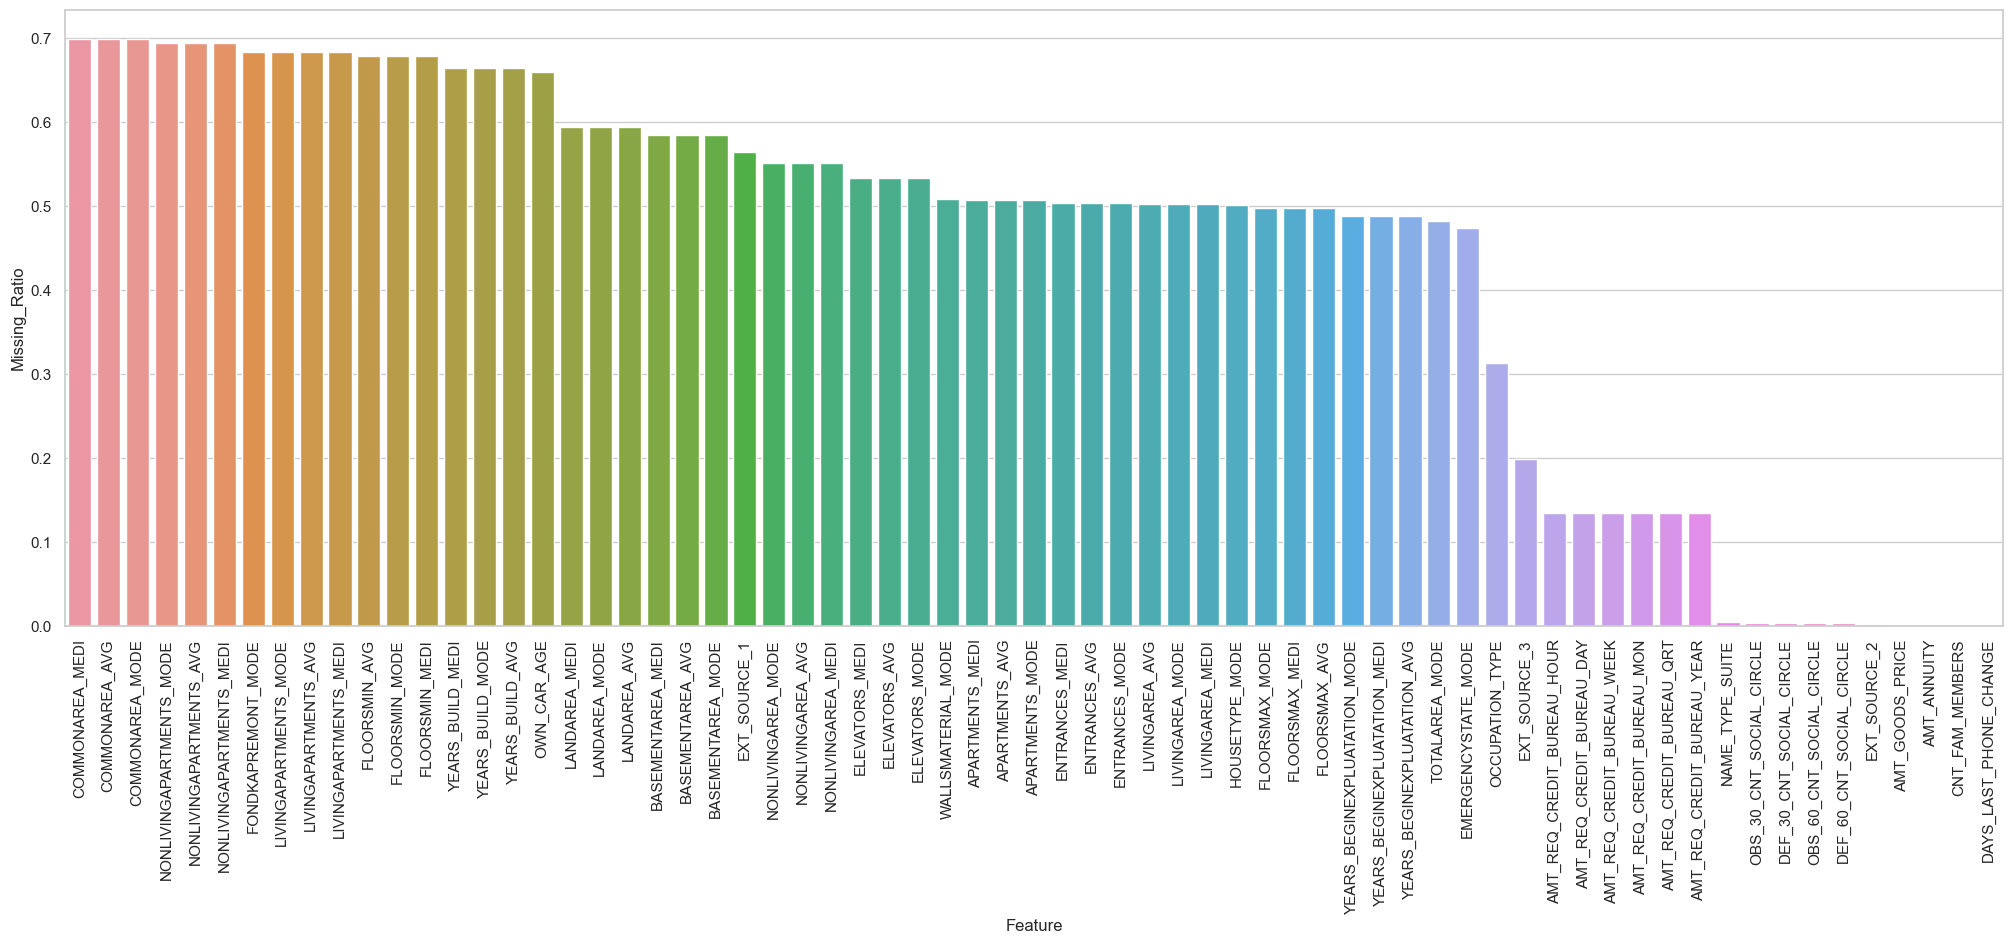

                         Feature  Num_Missing  Missing_Ratio DataTypes
0                COMMONAREA_MEDI       214865       0.698723   float64
1                 COMMONAREA_AVG       214865       0.698723   float64
2                COMMONAREA_MODE       214865       0.698723   float64
3       NONLIVINGAPARTMENTS_MODE       213514       0.694330   float64
4        NONLIVINGAPARTMENTS_AVG       213514       0.694330   float64
5       NONLIVINGAPARTMENTS_MEDI       213514       0.694330   float64
6             FONDKAPREMONT_MODE       210295       0.683862    object
7          LIVINGAPARTMENTS_MODE       210199       0.683550   float64
8           LIVINGAPARTMENTS_AVG       210199       0.683550   float64
9          LIVINGAPARTMENTS_MEDI       210199       0.683550   float64
10                 FLOORSMIN_AVG       208642       0.678486   float64
11                FLOORSMIN_MODE       208642       0.678486   float64
12                FLOORSMIN_MEDI       208642       0.678486   float64
13    

In [15]:
# Valeurs nulles sur le dataset 'application_train'
missing_values(train, 'application_train')

### Doublons

In [16]:
# Contrôle des doublons sur la feature 'SK_ID_CURR' du dataset 'train'
duplicates = train.duplicated(subset = 'SK_ID_CURR')
print(str(train[duplicates].size) + " doublons sur la feature SK_ID_CURR.")

0 doublons sur la feature SK_ID_CURR.


In [17]:
# Contrôle général des doublons sur le dataset 'train'
duplicates = train.duplicated()
print(str(train[duplicates].size) + " doublons dans le dataset train.")

0 doublons dans le dataset train.


## 2. Analyse de la target

#### Répartition brute de la target

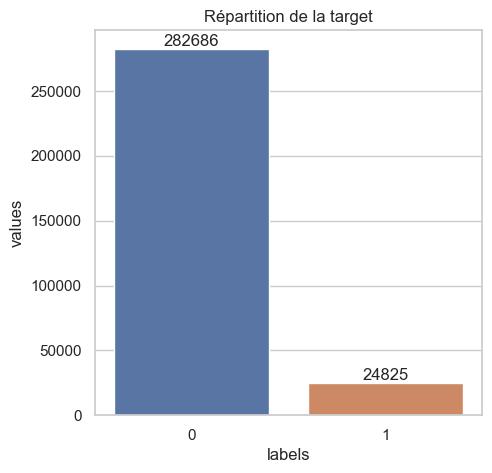

In [24]:
# Répartition de la target (1 vs 0)
TARGET = 'TARGET'

temp = train["TARGET"].value_counts()
df0 = pd.DataFrame({'labels': temp.index,
                   'values': temp.values
                  })
plt.figure(figsize = (5,5))
plt.title('Répartition de la target')
sns.set_color_codes("pastel")
ax = sns.barplot(x = 'labels', y = "values", data = df0)
ax.bar_label(ax.containers[0])
plt.show()

In [25]:
# Part des Revolving loans sur l'ensemble des prêts accordés
revolving = train[train['NAME_CONTRACT_TYPE'] == 'Revolving loans']
rev = round(revolving.shape[0] / train.shape[0],4)
rev = round(rev * 100, 2)
print('Part des Revolving loans : {}%'.format(rev))

Part des Revolving loans : 9.52%


### Analyse features catégorielles

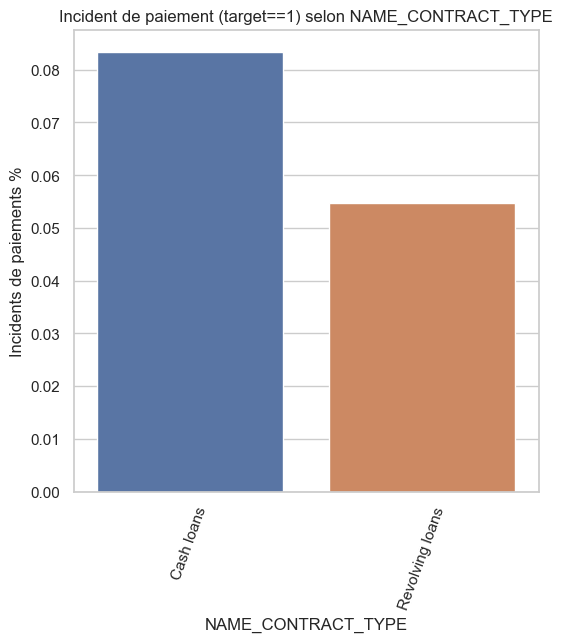

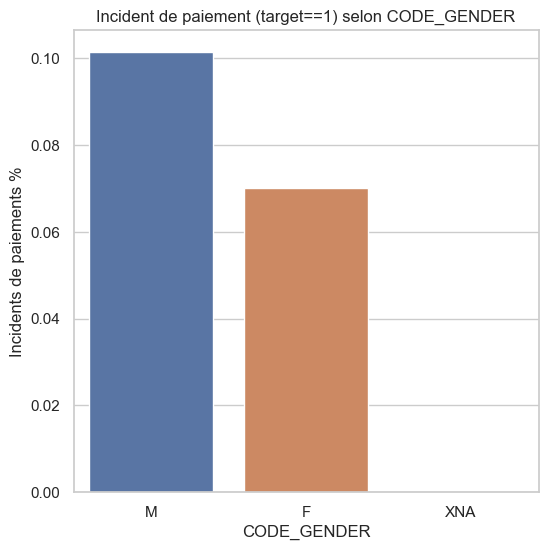

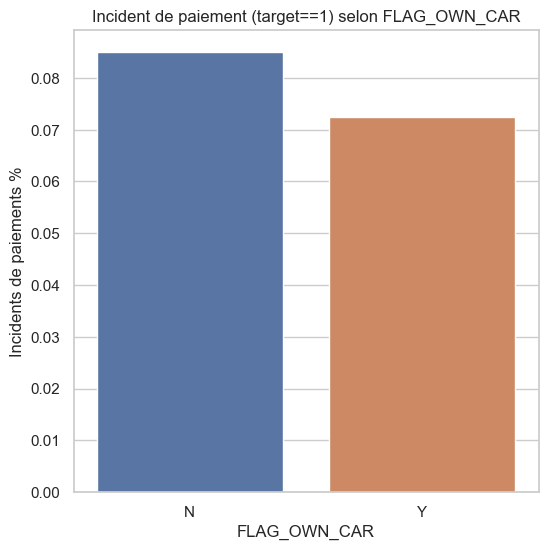

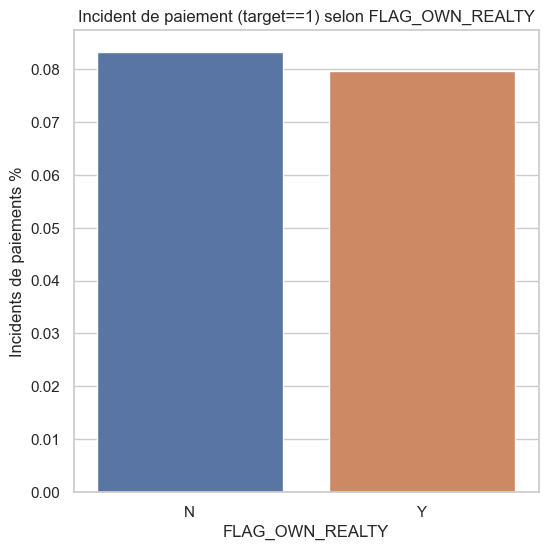

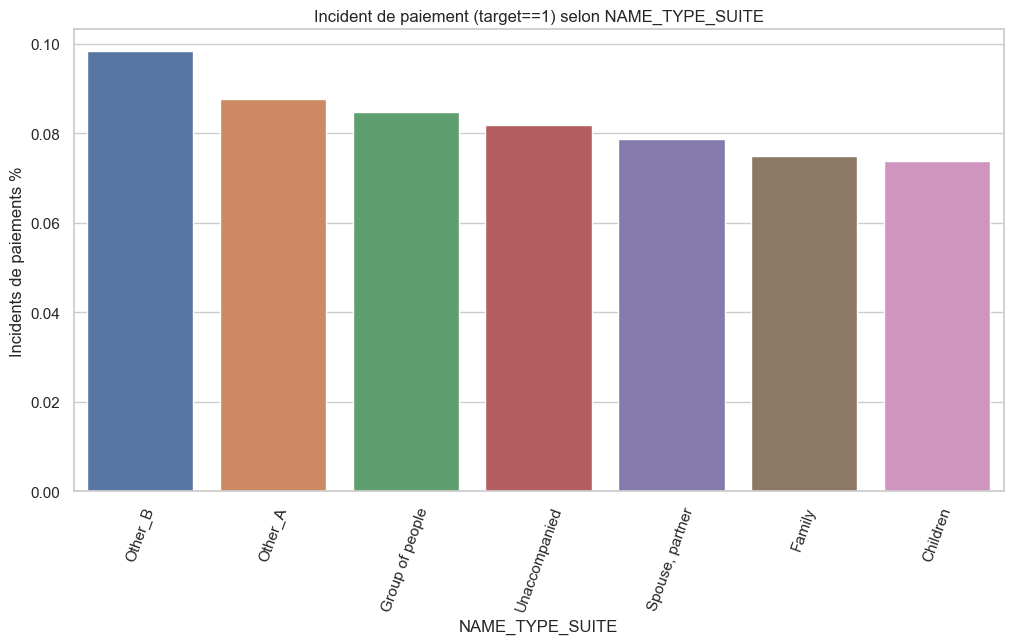

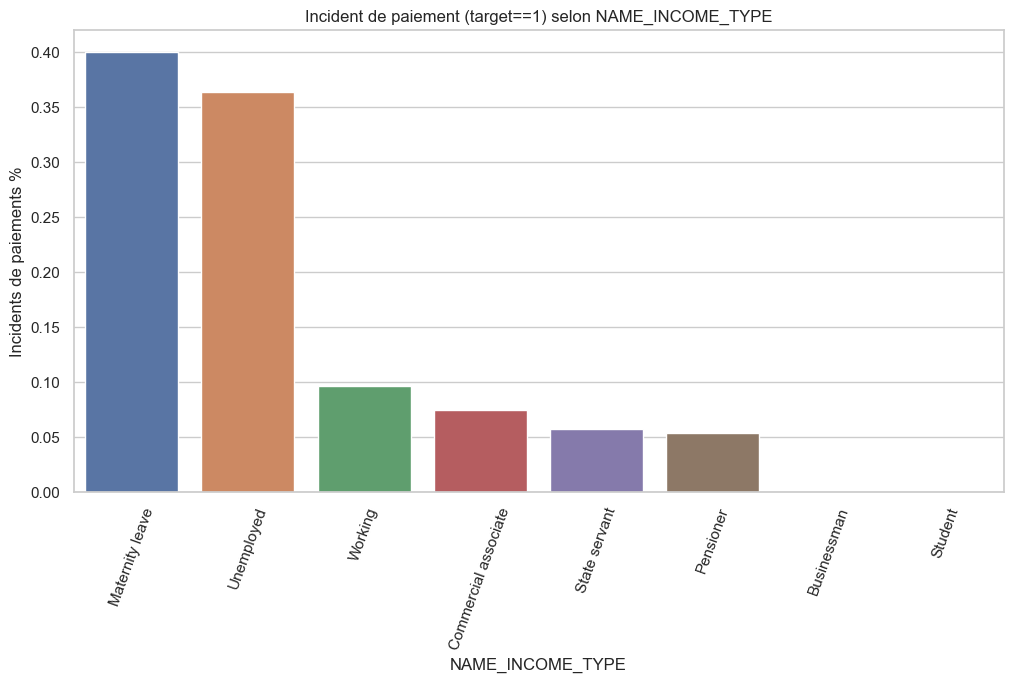

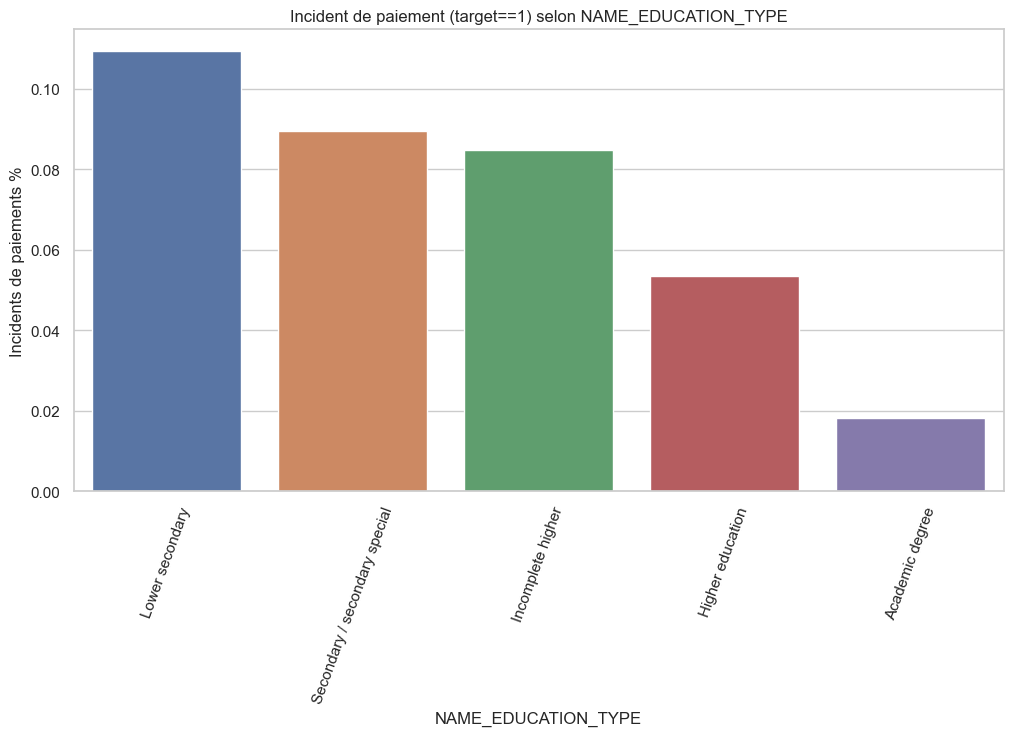

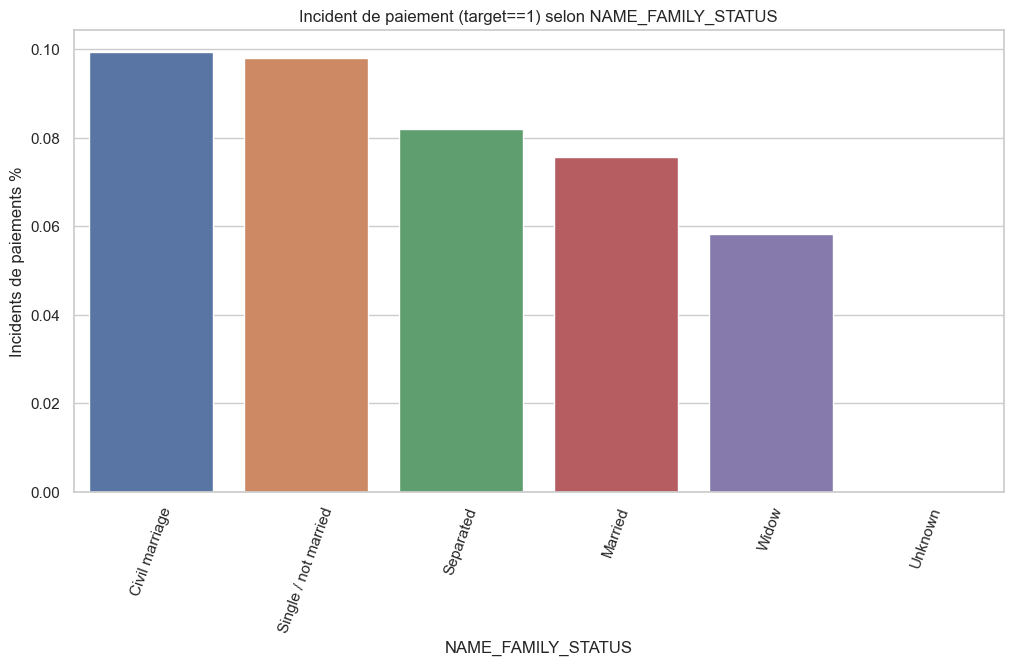

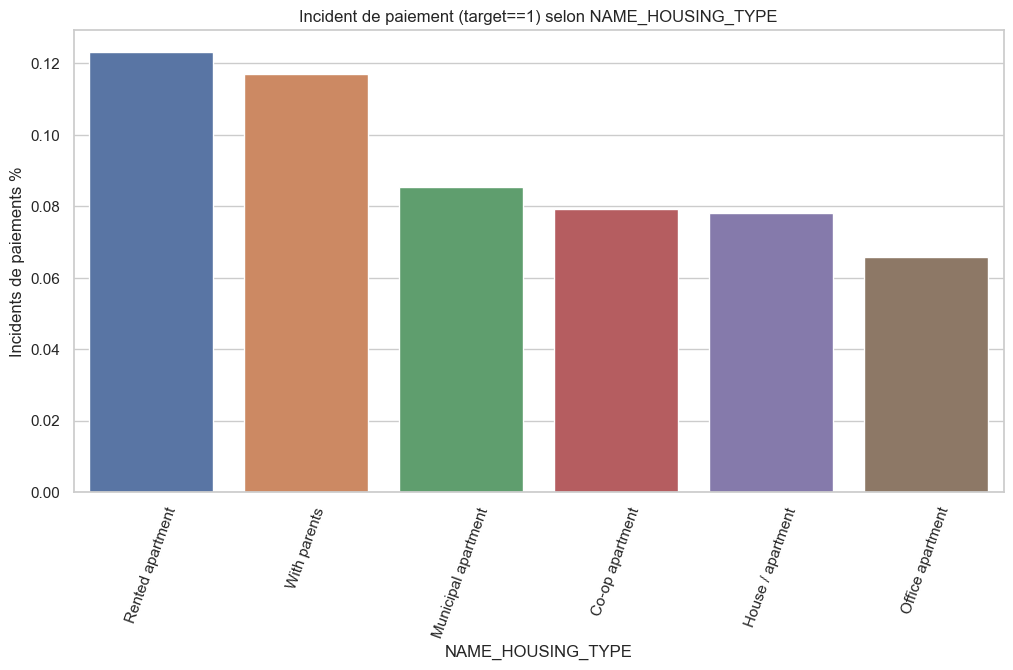

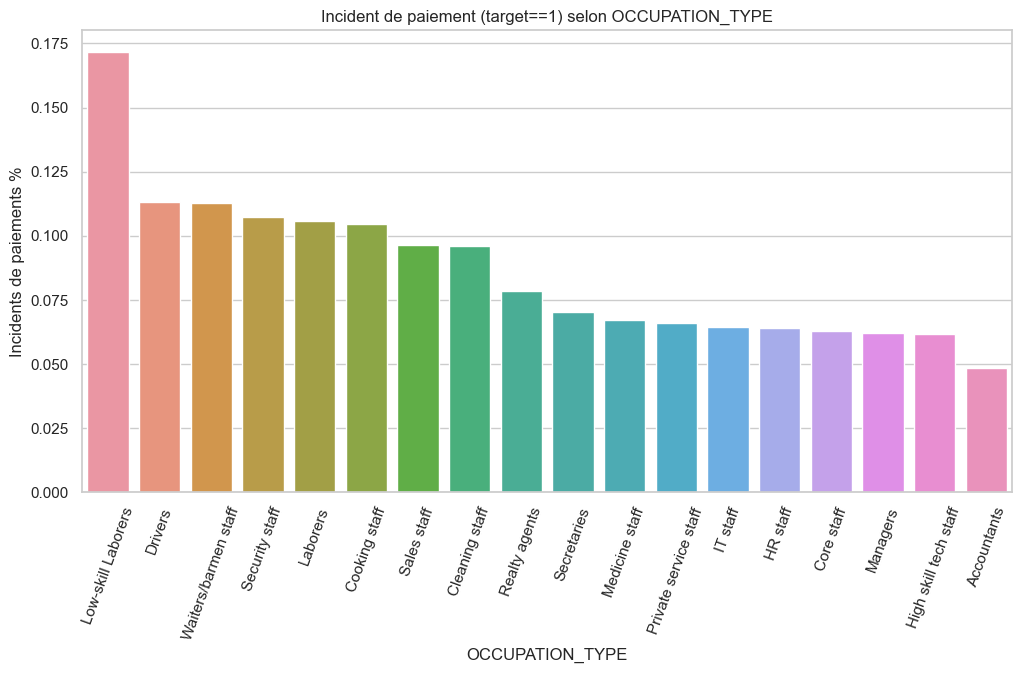

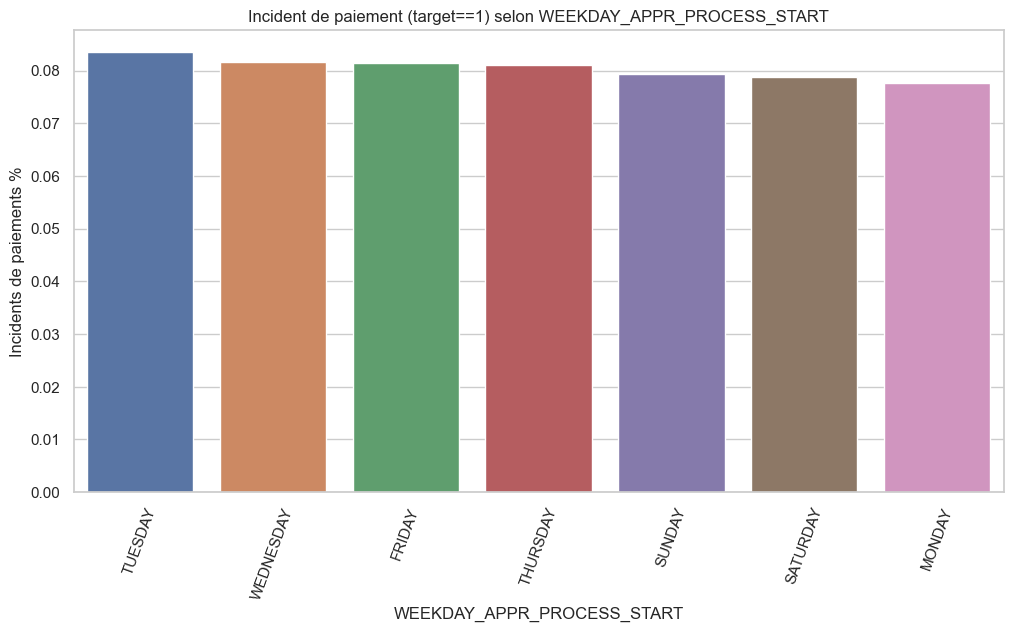

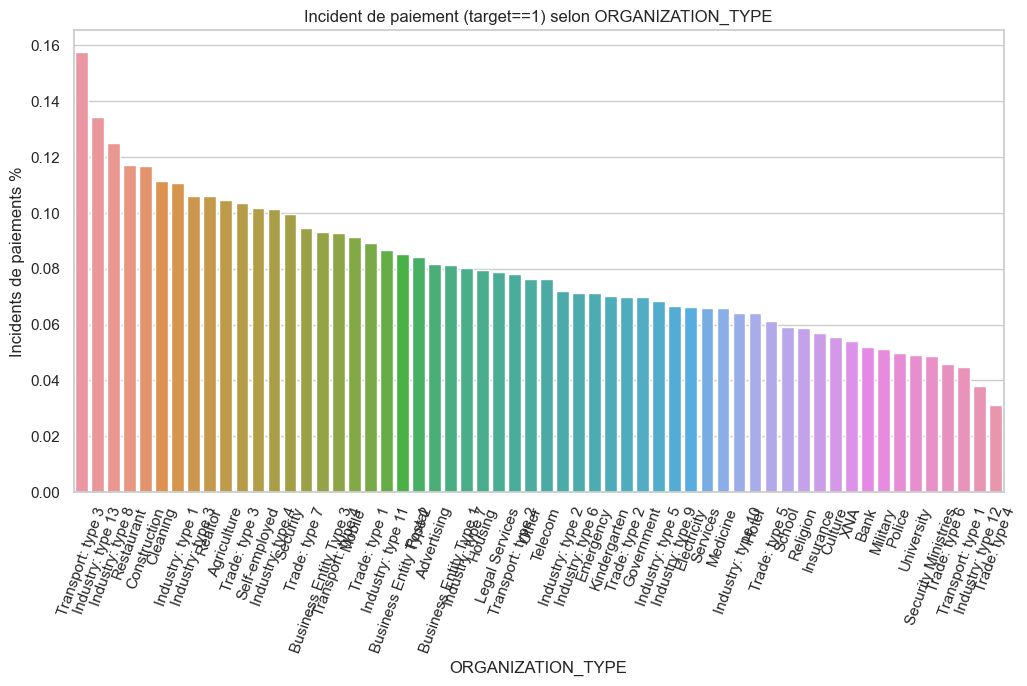

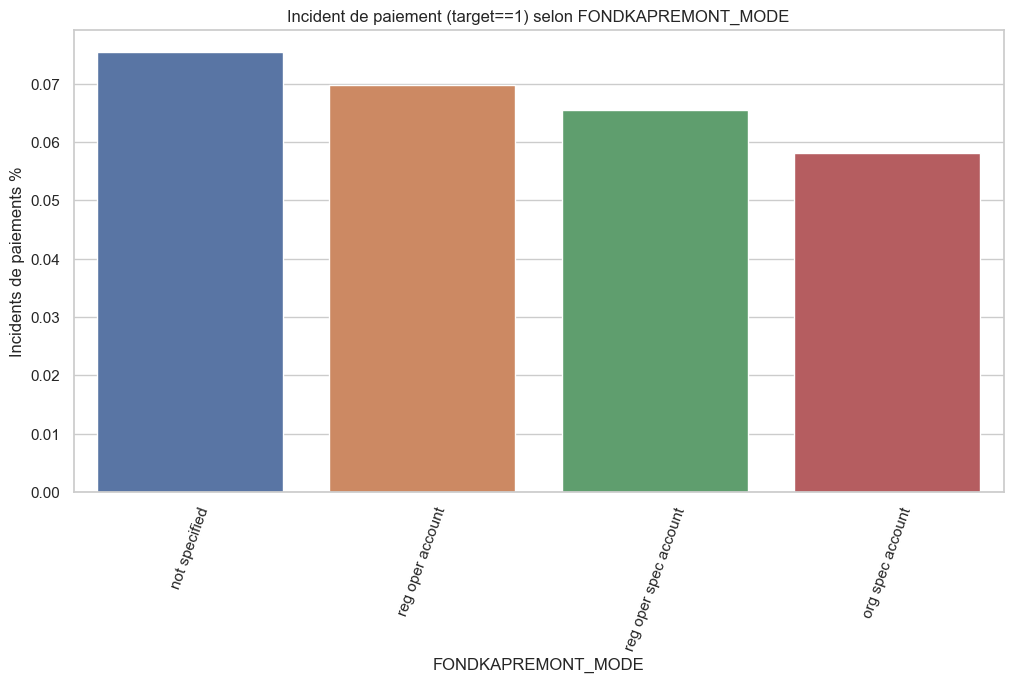

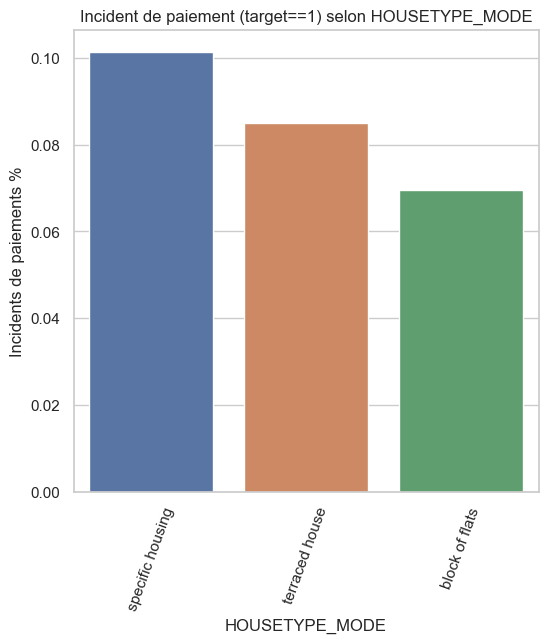

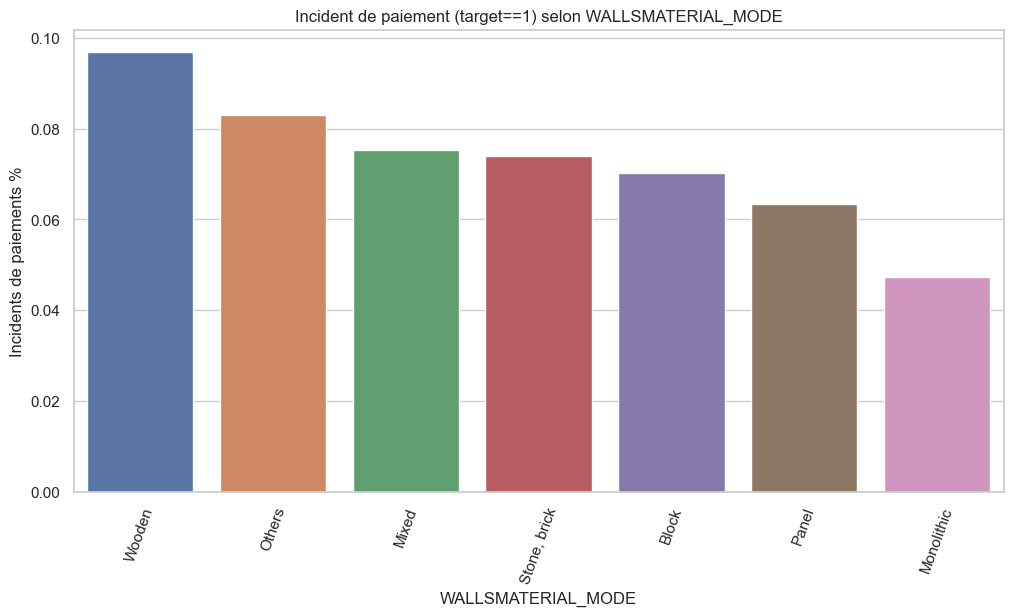

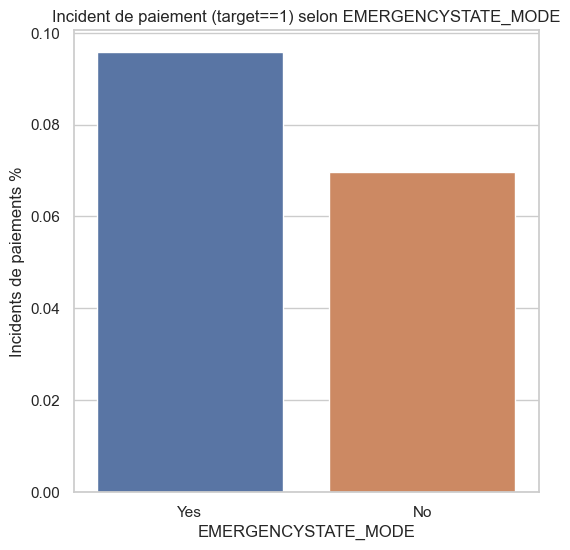

In [30]:
# Analyse de répartition des variables catégorielles selon TARGET (fonction)
for col in train.select_dtypes(object).columns:
    display_repay_failure_category(train, col)

### Analyse features numériques

In [34]:
# Définition des colonnes numériques à étudier
num_cols =['AMT_CREDIT',
           'AMT_ANNUITY',
           'AMT_GOODS_PRICE',
           'AMT_ANNUITY']

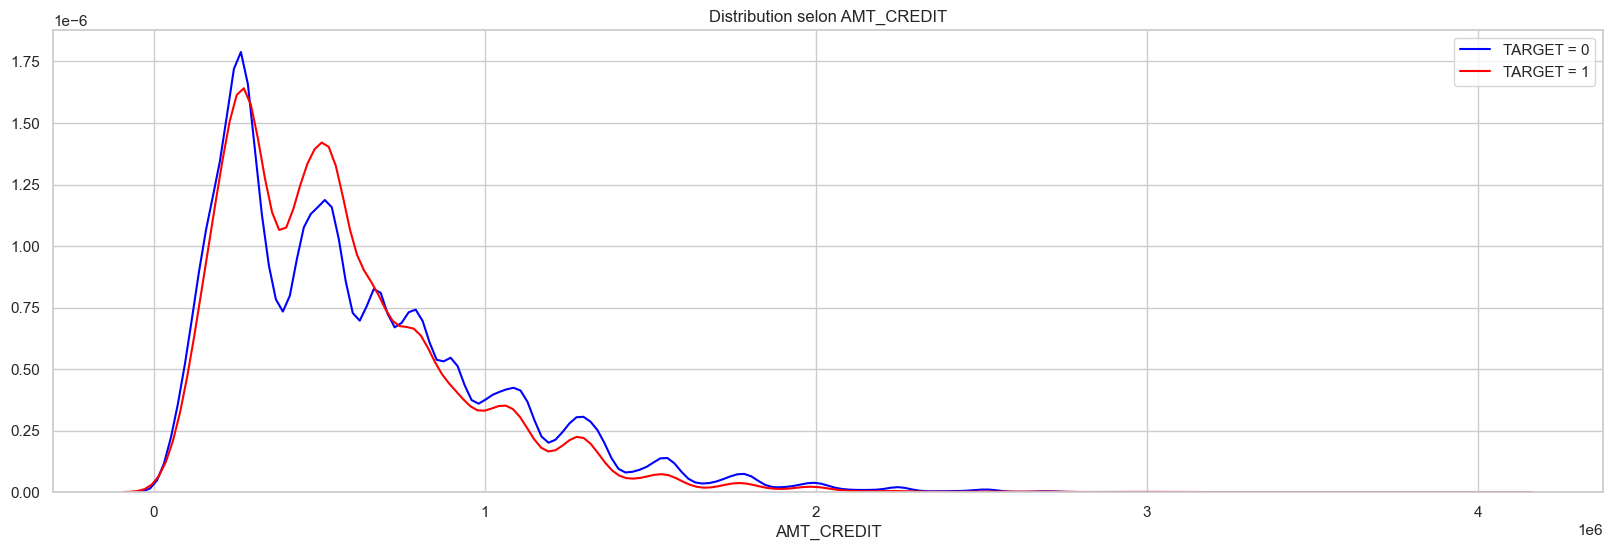

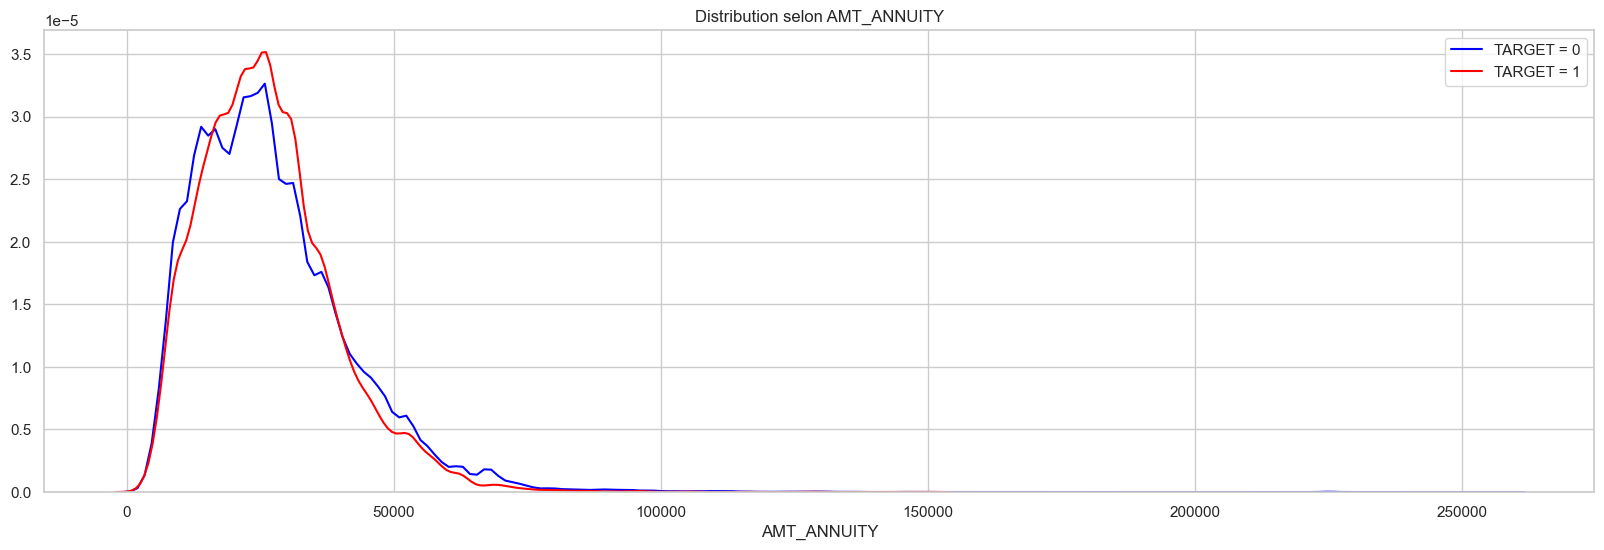

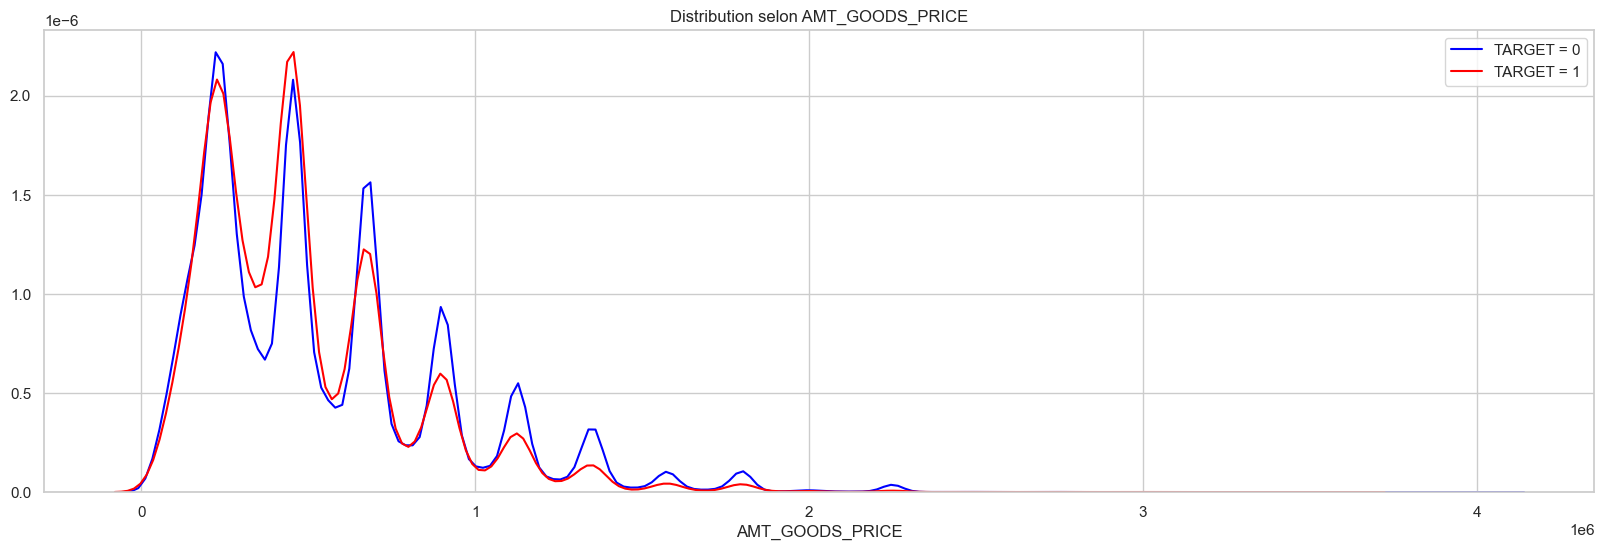

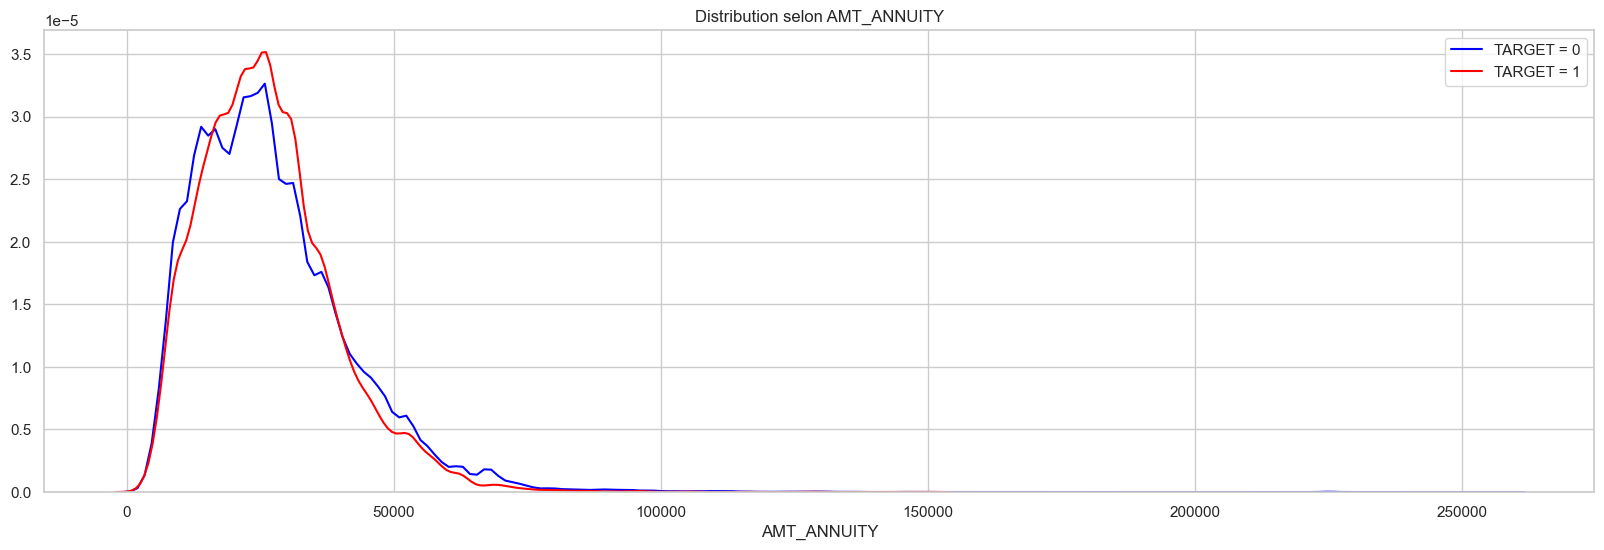

In [35]:
# Graphique : distribution variables numériques
for col in num_cols:
    plot_distribution(col)

### Analyse données temporelles

In [36]:
# Description des variables temporelles
display((train['DAYS_BIRTH'] /-365).describe())
display((train['DAYS_EMPLOYED'] /-365).describe())
display((train['DAYS_REGISTRATION'] /-365).describe())

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

count    307511.000000
mean       -174.835742
std         387.056895
min       -1000.665753
25%           0.791781
50%           3.323288
75%           7.561644
max          49.073973
Name: DAYS_EMPLOYED, dtype: float64

count    307511.000000
mean         13.660604
std           9.651743
min          -0.000000
25%           5.506849
50%          12.339726
75%          20.491781
max          67.594521
Name: DAYS_REGISTRATION, dtype: float64

Nous relevons une anomalie sur la feature 'DAYS_EMPLOYED' : -1000

#### Age des emprunteurs

Text(0, 0.5, 'Nb')

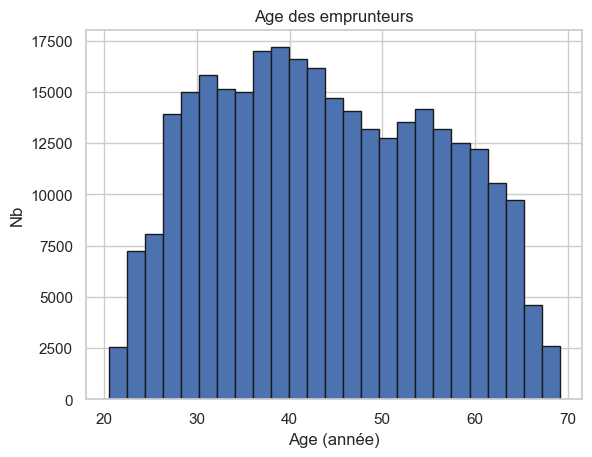

In [38]:
# Passage en valeur absolue : âge des emprunteurs
train['DAYS_BIRTH'] = abs(train['DAYS_BIRTH'])

# Représentation graphique : distribution
plt.hist(train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age des emprunteurs')
plt.xlabel('Age (année)')
plt.ylabel('Nb')

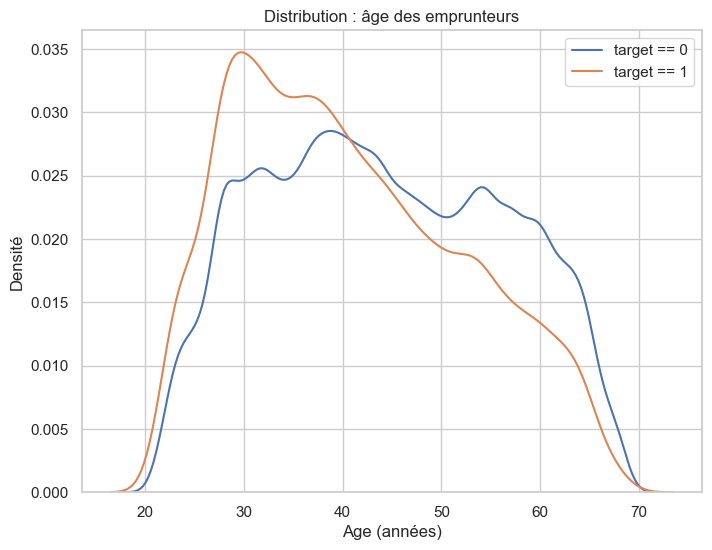

In [40]:
# Distribution : Age des emprunteurs selon TARGET
plt.figure(figsize = (8, 6))

sns.kdeplot(train.loc[train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')
sns.kdeplot(train.loc[train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

plt.xlabel('Age (années)')
plt.ylabel('Densité')
plt.title('Distribution : âge des emprunteurs')
plt.legend(loc='upper right')

#### Nombre de jours d'emploi des emprunteurs

In [49]:
# Défintion de l'anomalie relevée
anom_value = train['DAYS_EMPLOYED'].max()

# Remplacement des anomalies identifiées par NaN
train['DAYS_EMPLOYED'] = abs(train['DAYS_EMPLOYED'].replace({anom_value: np.nan}))

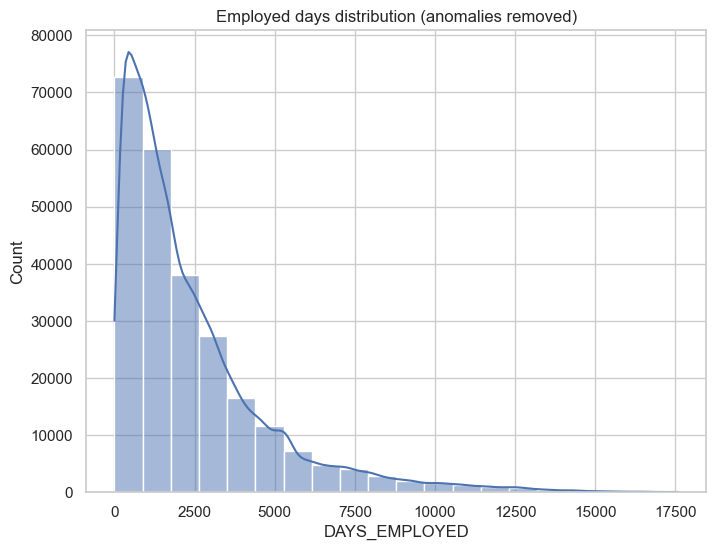

In [50]:
# Distribution brute
display_histplot(train, x='DAYS_EMPLOYED', kde=True, bins=20,
                 title="Employed days distribution (anomalies removed)")

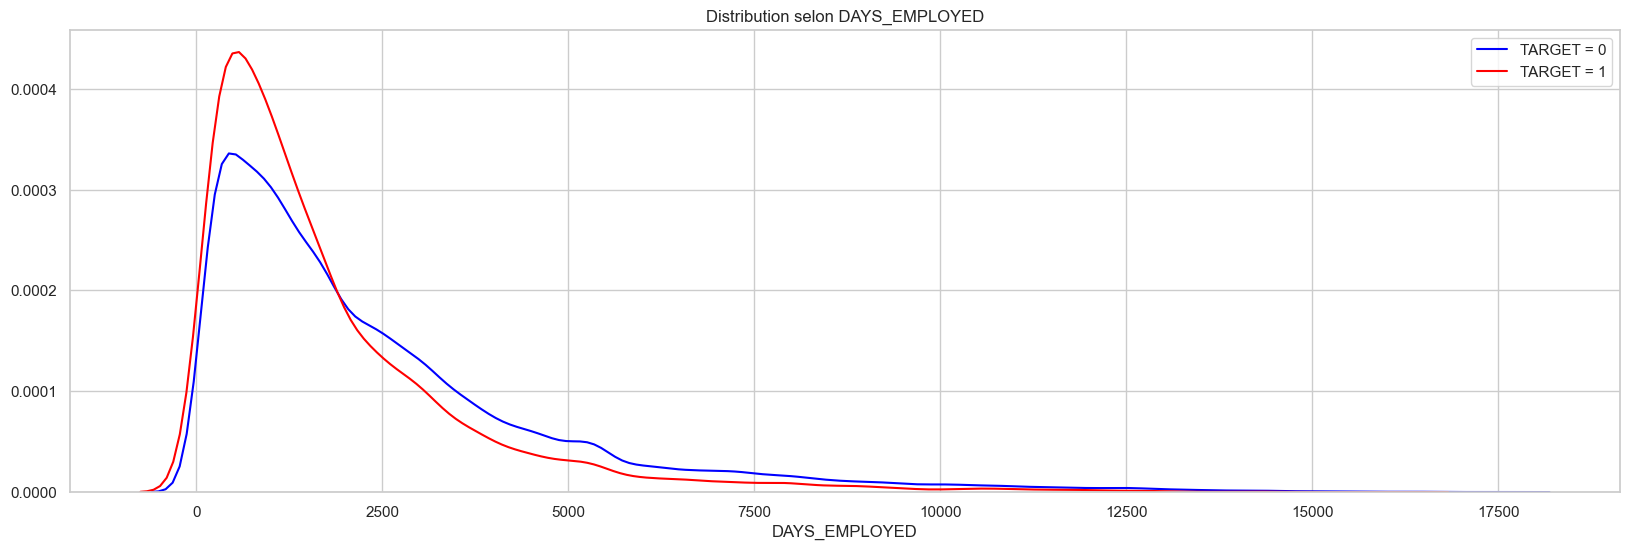

In [51]:
# Distribution selon target
plot_distribution('DAYS_EMPLOYED')

#### Days registration

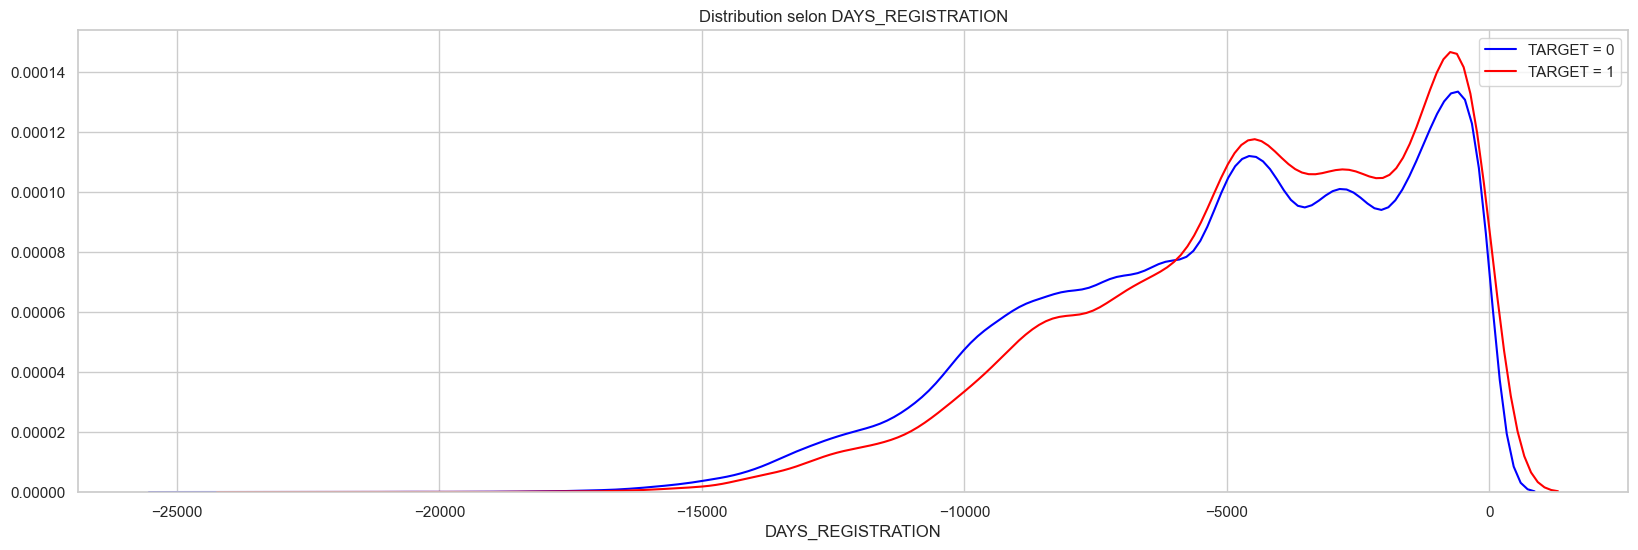

In [52]:
# Distribution selon TARGET
plot_distribution('DAYS_REGISTRATION')

#### Analyse de la target par tranches d'âge

In [57]:
# Création de la variable (variable initiale divisée par 365)
train['Estimated_age'] = train['DAYS_BIRTH']/365

# Découpage par tranches de 5 ans
train['Age_group'] = pd.cut(train['Estimated_age'], bins = np.linspace(20, 70, num = 11))
df_age = train[['TARGET', 'Estimated_age', 'Age_group']]

# Aperçu
df_age.head()

,TARGET,Estimated_age,Age_group
0,1,25.920548,"(25.0, 30.0]"
1,0,45.931507,"(45.0, 50.0]"
2,0,52.180822,"(50.0, 55.0]"
3,0,52.068493,"(50.0, 55.0]"
4,0,54.608219,"(50.0, 55.0]"


In [59]:
# Regroupement par tranches d'âge
df_age_group = df_age.groupby('Age_group').mean()

# Aperçu
df_age_group.head(10)

,TARGET,Estimated_age
Age_group,,
"(20.0, 25.0]",0.123036,23.377522
"(25.0, 30.0]",0.111436,27.822518
"(30.0, 35.0]",0.102814,32.479037
"(35.0, 40.0]",0.089414,37.555913
"(40.0, 45.0]",0.078491,42.459346
"(45.0, 50.0]",0.074171,47.462741
"(50.0, 55.0]",0.066968,52.593136
"(55.0, 60.0]",0.055314,57.491131
"(60.0, 65.0]",0.052737,62.412459


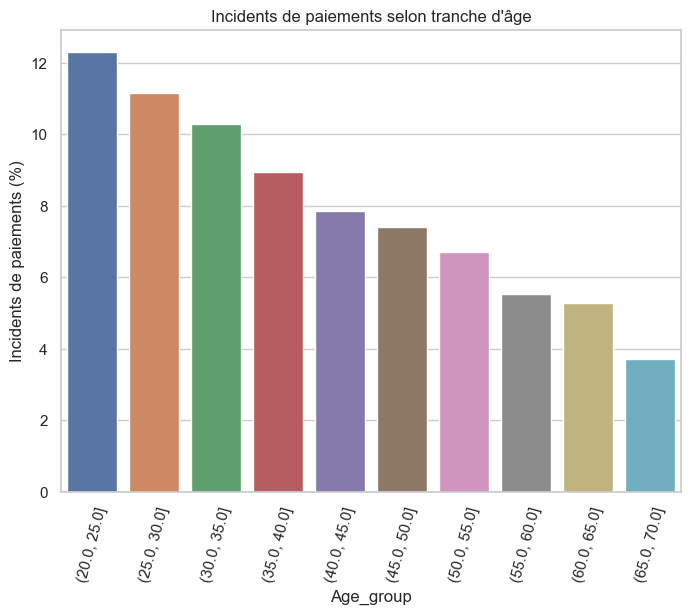

In [60]:
# Représentation graphique 
display_barplot(x=df_age_group.index.astype(str), y=100*df_age_group['TARGET'],
                title="Incidents de paiements selon tranche d'âge", xrotation=75, ylabel="Incidents de paiements (%)")